In [1]:
# https://github.com/scipy/scipy/issues/7151
# https://apps.dtic.mil/sti/pdfs/AD1004183.pdf
# https://www.codeproject.com/Articles/21282/Compute-Permanent-of-a-Matrix-with-Ryser-s-Algorit

# https://rosettacode.org/wiki/Determinant_and_permanent
# https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible

# https://stackoverflow.com/questions/38738835/generating-gray-codes
# https://qiita.com/b1ueskydragon/items/75cfee42541ea723080c

# https://qiita.com/phdax/items/3064de264c7933bab2f5
# https://web.archive.org/web/20190108235115/https://www.hackersdelight.org/hdcodetxt/pop.c.txt
# http://graphics.stanford.edu/~seander/bithacks.html#CountBitsSetParallel
# https://stackoverflow.com/questions/9829578/fast-way-of-counting-non-zero-bits-in-positive-integer

# https://stackoverflow.com/questions/22227595/convert-integer-to-binary-array-with-suitable-padding

In [2]:
import numpy as np
import time
from numba import jit
import scipy.special as spsp
import matplotlib.pyplot as plt

In [3]:
# https://github.com/XanaduAI/thewalrus/blob/master/thewalrus/_permanent.py

@jit(nopython=True)
def perm_bbfg(M):  # pragma: no cover
    """
    Returns the permanent of a matrix using the bbfg formula in Gray ordering
    The code is a re-implementation from a Python 2 code found in
    `Permanent code golf
    <https://codegolf.stackexchange.com/questions/97060/calculate-the-permanent-as-quickly-as-possible>`_
    using Numba.
    Args:
        M (array) : a square array.
    Returns:
        float or complex: the permanent of a matrix ``M``
    """

    n = len(M)
    if n == 0:
        return M.dtype.type(1.0)
    row_comb = np.sum(M, 0)
    total = 0
    old_gray = 0
    sign = +1
    binary_power_dict = np.array([2**i for i in range(n)])
    num_loops = 2 ** (n - 1)
    for bin_index in range(1, num_loops + 1):
        reduced = np.prod(row_comb)
        total += sign * reduced
        new_gray = bin_index ^ (bin_index // 2)
        gray_diff = old_gray ^ new_gray
        gray_diff_index = np.searchsorted(binary_power_dict,gray_diff)
        new_vector = M[gray_diff_index]
        direction = 2 * ((old_gray > new_gray) - (old_gray < new_gray))
        for i in range(n):
            row_comb[i] += new_vector[i] * direction
        sign = -sign
        old_gray = new_gray
    return total / num_loops

In [4]:
for L in range(4,6):
    a = np.ones((L,L),dtype=np.float64)
    #print(a)
    print("L:",L)
    start = time.time()
    print(perm_bbfg(a))
    end = time.time()
    print("time:",end-start)
    print("")

L: 4
24.0
time: 1.1755142211914062

L: 5
120.0
time: 1.811981201171875e-05



In [5]:
#L = 100
##L = 4
#L_A = 2
##L_A = 1
#tstep = 10.0

def calc_z(L,L_A,tstep):
    x = np.zeros((L,L), dtype = np.float64)
    for j in range(L):
        for k in range(L):
            x[j,k] = np.sin((j+1)*(k+1)*np.pi / (L+1))
    x *= np.sqrt(2.0 / (L+1))
    eps = np.array([-2.0 * np.cos((n+1) * np.pi / (L+1)) for n in range(L)])
    #
    ## y by definition
    y = x @ (np.diag(np.exp(1j * eps * tstep))) @ x
    ## y for thermodynamic limit
    y_inf = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            y_sub = (-1j)**(j-k) * (spsp.jn(j-k, 2.0 * tstep) + (-1)**(k) * spsp.jn(j+k+2, 2.0 * tstep))
            y_inf[j,k] = y_sub
    z = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            for m in range(L_A):
                z[j,k] += y[j,m].conjugate() * y[k,m]
    ## z for thermodynamic limit
    z_inf = np.zeros((L,L), dtype = np.complex128)
    for j in range(L):
        for k in range(L):
            for m in range(L_A):
                # z_inf[j,k] += y_inf[j,m].conjugate() * y_inf[k,m]
                z_inf[j,k] += (-1)**(k+1) * (+1j)**(j+k+2) * (spsp.jn(j-m, 2.0 * tstep) + (-1)**(m) * spsp.jn(j+m+2, 2.0 * tstep)) \
                    * (spsp.jn(k-m, 2.0 * tstep) + (-1)**(m) * spsp.jn(k+m+2, 2.0 * tstep))
    #
    dlt = np.identity(L,dtype=np.float64)
    matz = np.vstack( (np.hstack((z,dlt-z)), np.hstack((dlt-z,z))) )
    return matz, z, z_inf

#    ## check
#    j = 1
#    for k in range(L):
#        print(z[j,k], z_inf[j,k])

In [6]:
L = 8
L_A = 4
tstep = 1.0
matz, z, z_inf = calc_z(L,L_A,tstep)
#print(matz)
#print(z)

In [7]:
start = time.time()
print(perm_bbfg(matz))
end = time.time()
print("time:",end-start)
print("")

(0.1370061488038324-6.847207087229483e-16j)
time: 0.8328032493591309



In [8]:
L = 8
L_A = 4
ts = np.linspace(0,20,201)
data = []
for tstep in ts:
    matz, z, z_inf = calc_z(L,L_A,tstep)
    #print(tstep,-np.log(perm_bbfg(matz).real))
    data.append([tstep,-np.log(perm_bbfg(matz).real)])
data = np.array(data)

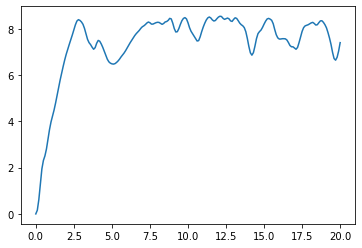

In [9]:
plt.plot(data[:,0],data[:,1]*2)